In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [3]:
ticker = "AAPL"
name = "Apple"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

2

In [ ]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

In [4]:
import pandas as pd
from market import services as market_services
days = 720
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

In [5]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tabulate import tabulate
import seaborn as sns

class SMACrossStrategy(bt.Strategy):
    params = (
        ('short_window', 5),
        ('long_window', 20),
        ('trade_size', 0.01),
    )

    def __init__(self):
        self.short_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_window)
        self.long_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_window)
        self.crossover = bt.indicators.CrossOver(self.short_ma, self.long_ma)
        self.trades = []
        self.trade_returns = []
        self.buys = []
        self.sells = []
        self.equity = []
        self.max_drawdown = 0
        self.peak_equity = 0

    def next(self):
        if self.crossover > 0:
            self.buys.append(pd.Timestamp(self.data.datetime[0]))
            if self.position.size < 0:
                self.close()
            self.buy(size=self.calculate_trade_size())
        elif self.crossover < 0:
            self.sells.append(pd.Timestamp(self.data.datetime[0]))
            if self.position.size > 0:
                self.close()
            self.sell(size=self.calculate_trade_size())
        
        current_equity = self.broker.getvalue()
        self.equity.append(current_equity)
        self.peak_equity = max(self.peak_equity, current_equity)
        drawdown = (self.peak_equity - current_equity) / self.peak_equity
        self.max_drawdown = max(self.max_drawdown, drawdown)

    def calculate_trade_size(self):
        trade_cash = self.broker.getvalue() * self.params.trade_size
        return self.broker.getposition(self.data).size or int(trade_cash / self.data.close[0])

    def notify_trade(self, trade):
        if trade.isclosed:
            self.trades.append(trade)
            returns = trade.pnlcomm / trade.price
            self.trade_returns.append(returns)

In [6]:
class BacktestingEngine:
    def __init__(self, ticker, data, initial_cash=100000.0, commission=0.001):
        self.ticker = ticker
        self.data = data
        self.initial_cash = initial_cash
        self.commission = commission
        self.results = None

    def run_backtest(self, short_window, long_window, trade_size):
        if self.data is None:
            print("No data available for backtesting")
            return None

        cerebro = bt.Cerebro()
        cerebro.broker.setcash(self.initial_cash)
        cerebro.broker.setcommission(commission=self.commission)
        cerebro.addstrategy(SMACrossStrategy,
                          short_window=int(short_window),
                          long_window=int(long_window),
                          trade_size=trade_size)
        
        cerebro.adddata(bt.feeds.PandasData(
            dataname=self.data,
            open='Open',
            high='High',
            low='Low',
            close='Close',
            volume='Volume'
        ))
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
        cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")

        self.results = cerebro.run()
        return self.results[0]

    def analyze_results(self, strategy, print_details=True, print_annual_metrics=True, print_trades_table=False):
        if strategy is None:
            print("No strategy results to analyze")
            return None

        max_drawdown = strategy.max_drawdown
        total_return = strategy.broker.getvalue() / self.initial_cash - 1
        total_return_cash = strategy.broker.getvalue() - self.initial_cash
        annual_metrics = self.calculate_annualized_metrics(strategy)
        
        if print_details:
            print("\n" + "="*50)
            print(f"Backtest Results for {self.ticker}:")
            print(f"\nDetailed Analysis:")
            print(f"Initial cash: {self.initial_cash}")
            print(f"Final cash: {strategy.broker.getvalue():.2f}")
            print(f"Total return (cash): {total_return_cash:.2f}")
            print(f"Total return (%): {total_return:.2%}")
            print(f"Max drawdown: {max_drawdown:.2%}")
            print(f"Number of trades: {len(strategy.trades)}")

        if print_annual_metrics:
            print("\n" + "="*50)
            print("\nAnnualized Metrics:")
            print(f"Annual return: {annual_metrics['Annual Return']:.2%}")
            print(f"Annual volatility: {annual_metrics['Annual Volatility']:.2%}")
            print(f"Sharpe ratio: {annual_metrics['Sharpe Ratio']:.4f}")

        if print_trades_table:
            trades = []
            for trade in strategy.trades:
                trades.append([trade.ref, trade.dtopen, trade.dtclose, trade.pnl, trade.pnlcomm])
            trades_df = pd.DataFrame(trades, columns=['Trade ID', 'Open Date', 'Close Date', 'Profit/Loss', 'PnL (incl. commission)'])
            print("\n" + "="*50)
            print("\nTrades:")
            print(tabulate(trades_df, headers='keys', tablefmt='psql'))
        
        return {
            'sharpe_ratio': annual_metrics['Sharpe Ratio'],
            'annual_return': annual_metrics['Annual Return'],
            'annual_volatility': annual_metrics['Annual Volatility'],
            'max_drawdown': max_drawdown,
            'total_return': total_return
        }

    def plot_results(self, short_window, long_window, trade_size):
        strategy = self.run_backtest(short_window, long_window, trade_size)
        if strategy is None:
            return

        buy_dates = [d.floor('D') for d in strategy.buys]
        sell_dates = [d.floor('D') for d in strategy.sells]
        valid_buys = [d for d in buy_dates if d in self.data.index]
        valid_sells = [d for d in sell_dates if d in self.data.index]

        fig, ax = plt.subplots(figsize=(15, 8))
        ax.plot(self.data.index, self.data['Close'], label='Close Price', alpha=0.7)
        ax.plot(self.data.index, self.data['Close'].rolling(window=short_window).mean(),
                label=f'{short_window}-day SMA', alpha=0.7)
        ax.plot(self.data.index, self.data['Close'].rolling(window=long_window).mean(),
                label=f'{long_window}-day SMA', alpha=0.7)
        
        if valid_buys:
            ax.scatter(valid_buys, self.data.loc[valid_buys]['Close'],
                       marker='^', color='g', label='Buy Signal', alpha=1, s=200)
        if valid_sells:
            ax.scatter(valid_sells, self.data.loc[valid_sells]['Close'],
                       marker='v', color='r', label='Sell Signal', alpha=1, s=200)

        for buy_date in valid_buys:
            ax.axvline(x=buy_date, color='g', linestyle='--', alpha=0.5)
        for sell_date in valid_sells:
            ax.axvline(x=sell_date, color='r', linestyle='--', alpha=0.5)
            
        ax.set_title(f'SMA Crossover Strategy: {self.ticker}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)

        analysis = self.analyze_results(strategy, print_details=False)
        performance_text = (
            f"Sharpe Ratio: {analysis['sharpe_ratio']:.4f}\n"
            f"Annual Return: {analysis['annual_return']:.2%}\n"
            f"Annual Volatility: {analysis['annual_volatility']:.2%}\n"
            f"Max Drawdown: {analysis['max_drawdown']:.2%}\n"
            f"Total Return: {analysis['total_return']:.2%}"
        )
        plt.text(0.05, 0.95, performance_text, transform=ax.transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        plt.tight_layout()
        plt.show()

    def calculate_annualized_metrics(self, strategy, risk_free_rate=0.00):
        first_date = self.data.index.min()
        last_date = self.data.index.max()
        total_days = (last_date - first_date).days
        annual_factor = 252 / total_days if total_days > 0 else 1

        daily_returns = pd.Series(strategy.equity).pct_change().dropna()
        
        if len(daily_returns) > 0:
            total_return = (strategy.broker.getvalue() / self.initial_cash) - 1
            annual_return = (1 + total_return) ** annual_factor - 1
            annual_volatility = daily_returns.std() * np.sqrt(252)
            sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility != 0 else 0
        else:
            annual_return = annual_volatility = sharpe_ratio = 0

        return {
            "Annual Return": annual_return,
            "Annual Volatility": annual_volatility,
            "Sharpe Ratio": sharpe_ratio,
        }

    def optimize_parameters(self, short_window_range, long_window_range, trade_size_range):
        results = []
        for short, long, size in product(short_window_range, long_window_range, trade_size_range):
            if short >= long:
                continue
            strategy = self.run_backtest(short, long, size)
            if strategy is None:
                continue
            analysis = self.analyze_results(strategy, print_details=False, print_annual_metrics=False)
            if analysis is None:
                continue
            results.append({
                'short_window': short,
                'long_window': long,
                'trade_size': size,
                'total_trades': len(strategy.trades),
                'sharpe_ratio': analysis['sharpe_ratio'],
                'total_return': analysis['total_return'],
                'max_drawdown': analysis['max_drawdown'],
                'annual_return': analysis['annual_return'],
                'annual_volatility': analysis['annual_volatility']
            })
            print(f"Processed: Short={short}, Long={long}, Trade Size={size:.2%}, Sharpe={analysis['sharpe_ratio']:.4f}, Return={analysis['total_return']:.2%}")
        
        return pd.DataFrame(results).sort_values('sharpe_ratio', ascending=False).reset_index(drop=True)

    def display_optimization_results(self, results_df, top_n=10):
        print(f"\nTop {top_n} Optimization Results:")
        print(tabulate(results_df.head(top_n), headers='keys', tablefmt='psql', floatfmt=".4f"))
        
        pivot_df = results_df.groupby(['short_window', 'long_window'])['sharpe_ratio'].mean().unstack()
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
        plt.title('Sharpe Ratio Heatmap')
        plt.xlabel('Long Window')
        plt.ylabel('Short Window')
        plt.show()

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
        surf = ax.plot_surface(X, Y, pivot_df.values, cmap='viridis')
        ax.set_xlabel('Long Window')
        ax.set_ylabel('Short Window')
        ax.set_zlabel('Sharpe Ratio')
        plt.title('3D Sharpe Ratio Surface')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

In [8]:
# Load your Django data
import setup
from market.models import Company
from market import services as market_services

ticker = "AAPL"
days = 720

# Get data from TimescaleDB
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

# Convert to DataFrame and clean
df = pd.DataFrame.from_records(list(queryset.values()))
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# FIRST rename columns, THEN convert types
df = df.rename(columns={
    'open_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'close_price': 'Close',
    'volume': 'Volume'
})

# Now convert to float
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)

# Handle datetime index
df.index = df.index.normalize().tz_localize(None)

# Select final columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Verify cleaned data
print("Cleaned Data Summary:")
print(f"Columns: {df.columns.tolist()}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"\nSample Data:\n{df.head(3)}")

Cleaned Data Summary:
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
Date Range: 2023-03-02 00:00:00 to 2025-01-25 00:00:00

Sample Data:
              Open    High     Low   Close  Volume
time                                              
2023-03-02  145.45  145.45  145.45  145.45    2337
2023-03-03  151.08  151.10  151.08  151.10    5059
2023-03-04  151.26  151.42  151.25  151.42   11194


Processed: Short=5, Long=20, Trade Size=5.00%, Sharpe=0.1422, Return=0.43%
Processed: Short=5, Long=20, Trade Size=10.00%, Sharpe=0.1417, Return=0.85%
Processed: Short=5, Long=40, Trade Size=5.00%, Sharpe=-0.5989, Return=-1.84%
Processed: Short=5, Long=40, Trade Size=10.00%, Sharpe=-0.5922, Return=-3.74%
Processed: Short=5, Long=60, Trade Size=5.00%, Sharpe=-0.1036, Return=-0.32%
Processed: Short=5, Long=60, Trade Size=10.00%, Sharpe=-0.1032, Return=-0.66%
Processed: Short=5, Long=80, Trade Size=5.00%, Sharpe=0.1740, Return=0.58%
Processed: Short=5, Long=80, Trade Size=10.00%, Sharpe=0.1730, Return=1.15%
Processed: Short=5, Long=100, Trade Size=5.00%, Sharpe=0.0939, Return=0.32%
Processed: Short=5, Long=100, Trade Size=10.00%, Sharpe=0.0934, Return=0.63%
Processed: Short=5, Long=120, Trade Size=5.00%, Sharpe=0.2702, Return=0.91%
Processed: Short=5, Long=120, Trade Size=10.00%, Sharpe=0.2703, Return=1.84%
Processed: Short=10, Long=20, Trade Size=5.00%, Sharpe=-0.1709, Return=-0.51%
Proc

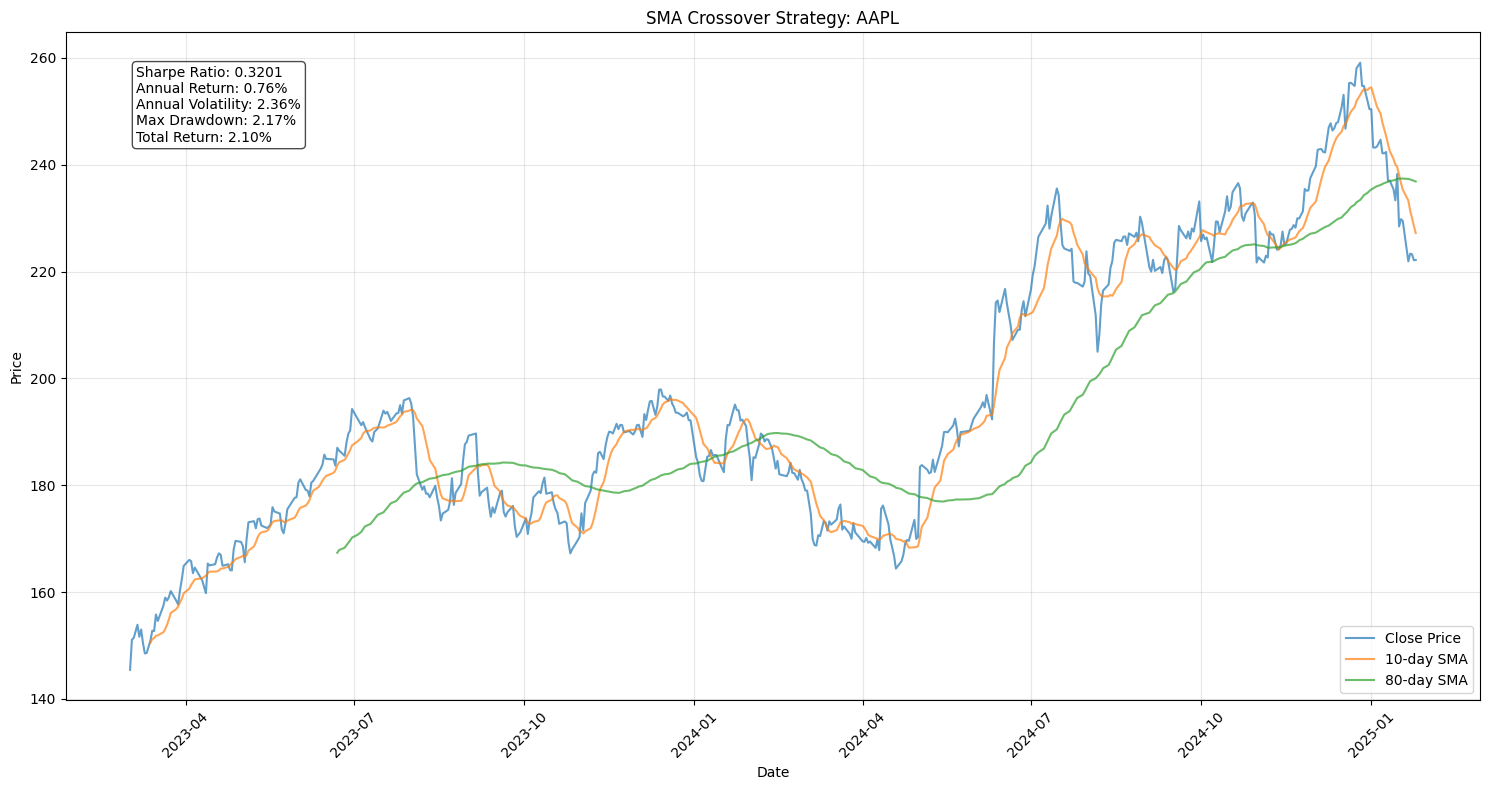


Top 10 Optimization Results:
+----+----------------+---------------+--------------+----------------+----------------+----------------+----------------+-----------------+---------------------+
|    |   short_window |   long_window |   trade_size |   total_trades |   sharpe_ratio |   total_return |   max_drawdown |   annual_return |   annual_volatility |
|----+----------------+---------------+--------------+----------------+----------------+----------------+----------------+-----------------+---------------------|
|  0 |        10.0000 |       80.0000 |       0.1000 |        10.0000 |         0.3201 |         0.0210 |         0.0217 |          0.0076 |              0.0236 |
|  1 |        10.0000 |       80.0000 |       0.0500 |        10.0000 |         0.3200 |         0.0105 |         0.0109 |          0.0038 |              0.0119 |
|  2 |         5.0000 |      120.0000 |       0.1000 |         6.0000 |         0.2703 |         0.0184 |         0.0171 |          0.0066 |              0

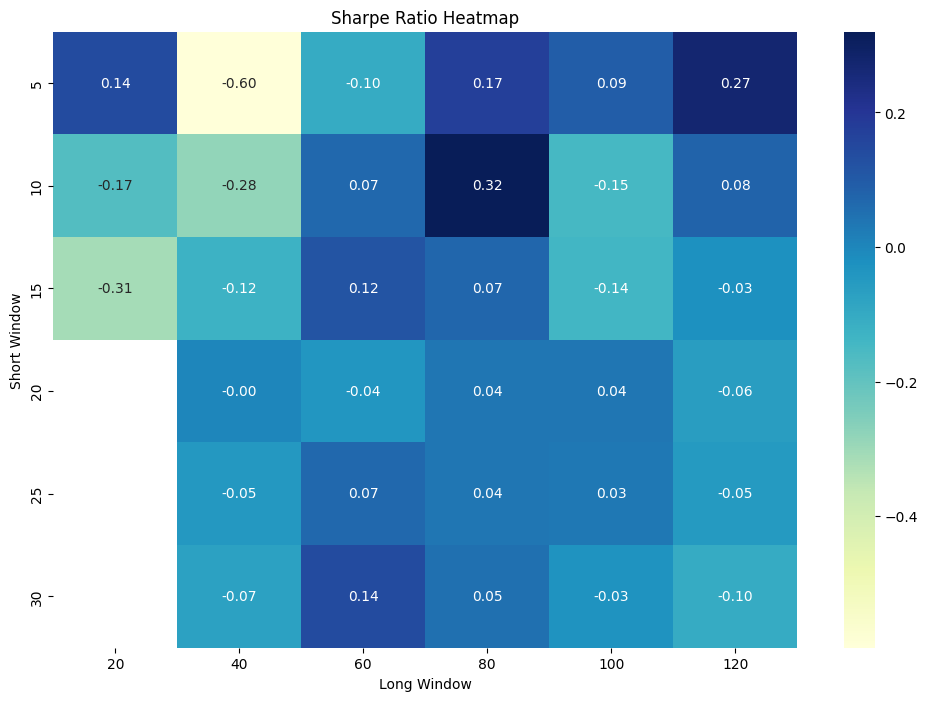

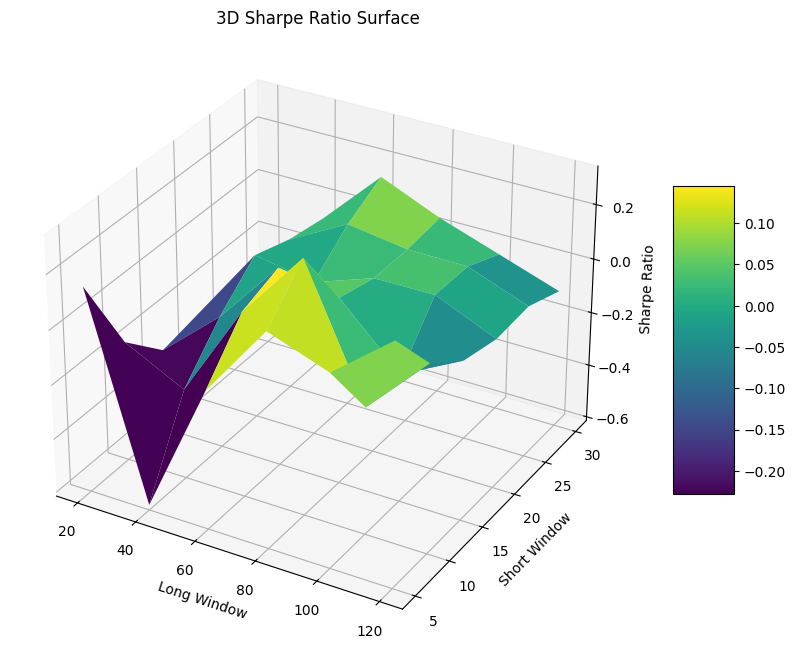

In [9]:
if __name__ == "__main__":
    # Initialize with cleaned data
    engine = BacktestingEngine(
        ticker='AAPL', 
        data=df,
        initial_cash=100000.0
    )
    
    # Adjusted parameter ranges for 2-year data
    short_ma_range = range(5, 31, 5)    # 5-30 days
    long_ma_range = range(20, 121, 20)  # 20-120 days
    trade_size_range = [0.05, 0.1]      # 5-10% position sizes
    
    # Run optimization
    optimized_results = engine.optimize_parameters(
        short_ma_range, 
        long_ma_range, 
        trade_size_range
    )
    
    # Display results
    if not optimized_results.empty:
        best_params = optimized_results.iloc[0]
        print("\nBest Parameters:")
        print(f"Short SMA: {best_params['short_window']} days")
        print(f"Long SMA: {best_params['long_window']} days")
        print(f"Trade Size: {best_params['trade_size']:.2%}")
        engine.plot_results(
            int(best_params['short_window']), 
            int(best_params['long_window']), 
            best_params['trade_size']
        )
        engine.display_optimization_results(optimized_results)
    else:
        print("Optimization failed to produce valid results.")